## Variational AutoEncoder - Part 1

In [39]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

In [43]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
reshape=False # Only for GAN for encoder it is different boolean

In [44]:
# Normalizing the values to be between 0 and 1 since the values are in gray scales 
# in between 0 and 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [45]:
# Reshape the training and testing data to be as an one dimensional array
if reshape:
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [46]:
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


### VAE Network Parameters

In [6]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 50

### VAE: -> Encoder - from image to the latent parameters, decoder, reparametrization trick

In [7]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0822 11:05:37.751042 140303666841408 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 11:05:37.773864 140303666841408 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 11:05:37.775046 140303666841408 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [8]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [9]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [10]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [11]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [12]:
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [13]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [14]:
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

### Loss is calculated using reconstruction loss and KL divergence term

In [15]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='adam', loss=total_loss)

W0822 11:05:37.914145 140303666841408 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0822 11:05:37.932546 140303666841408 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0822 11:05:37.938208 140303666841408 deprecation.py:323] From /home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [17]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [18]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
decode_intermediate (Dense)  (None, 512)               1536      
_________________________________________________________________
decode_full (Dense)          (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [19]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [20]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0822 11:05:38.259911 140303666841408 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 182us/step - loss: 196.1141 - val_loss: 169.1016
Epoch 2/50
60000/60000 [==============================] - 11s 178us/step - loss: 166.5620 - val_loss: 163.3165
Epoch 3/50
60000/60000 [==============================] - 10s 159us/step - loss: 162.4302 - val_loss: 160.8132
Epoch 4/50
60000/60000 [==============================] - 10s 169us/step - loss: 160.2309 - val_loss: 159.0932
Epoch 5/50
60000/60000 [==============================] - 11s 188us/step - loss: 158.6288 - val_loss: 157.6106
Epoch 6/50
60000/60000 [==============================] - 10s 160us/step - loss: 157.5552 - val_loss: 156.8214
Epoch 7/50
60000/60000 [==============================] - 9s 155us/step - loss: 156.6044 - val_loss: 155.8761
Epoch 8/50
60000/60000 [==============================] - 13s 211us/step - loss: 155.6360 - val_loss: 155.0553
Epoch 9/50
60000/60000 [==============================] - 10s 1

In [21]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [22]:
x_test_encoded.shape

(10000, 2)

In [23]:
x_test_encoded[:10]

array([[-2.3970976 , -2.1053987 ],
       [ 0.67300314,  0.77305394],
       [ 2.655113  , -3.0938811 ],
       [ 1.4583703 ,  3.1553178 ],
       [-1.4982867 ,  0.3246405 ],
       [ 2.2881966 , -2.6865487 ],
       [-1.52466   , -0.49132478],
       [-2.7174304 ,  0.35580727],
       [-0.29422358, -0.19481705],
       [-0.7826917 , -1.4303076 ]], dtype=float32)

### Latent space

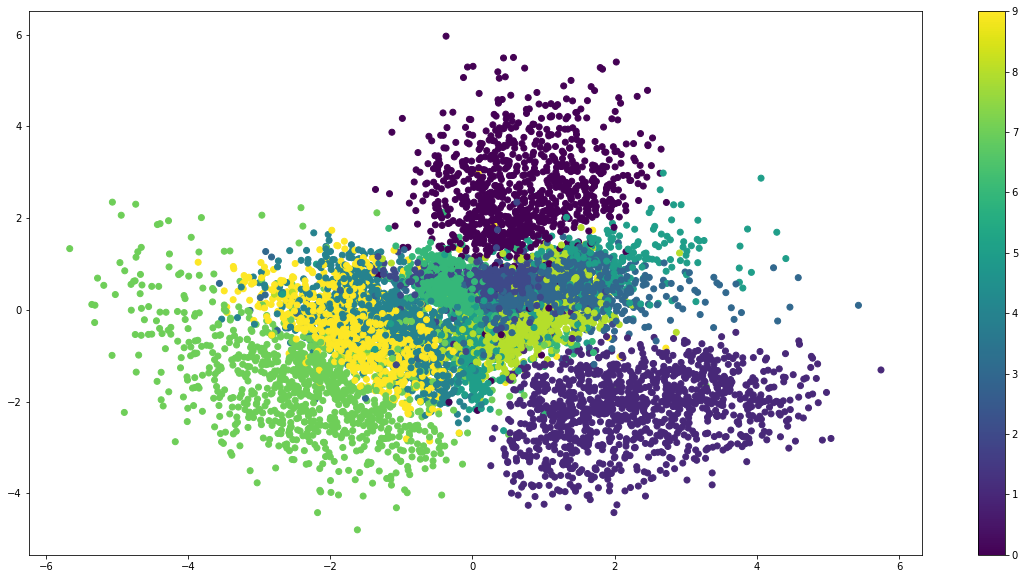

In [24]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

### Generating the new digits

In [60]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

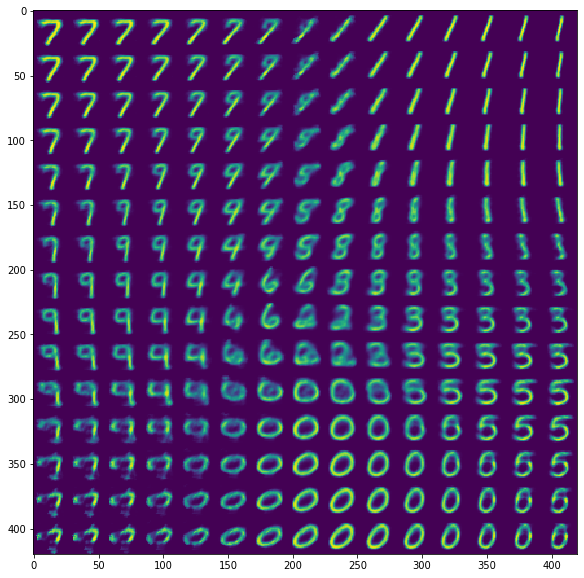

In [61]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

## Sampling strategies for latent space

## GANs in general

In [47]:
from tqdm import tqdm_notebook

In [48]:
from keras.models import Sequential
from keras.layers import Reshape, Flatten, LeakyReLU, BatchNormalization

In [49]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [50]:
image_shape = (28, 28, 1)

In [51]:
latent_space_dimensions = (100,)
latent_input = Input(shape=latent_space_dimensions)

In [52]:
def build_discriminator():
    # Shape of the image which is in 1D - 784 pixels and in 2D it is 28 * 28 pixels
    model = Sequential()
    # Flatten the image into 1D from 2D image
    img = Input(shape=image_shape)
    flattened_image = Flatten(input_shape=image_shape)(img)
    # Add a fully connected layer with leaky relu
    first_fc = Dense(512)(flattened_image)
    first_act = LeakyReLU(alpha=0.2)(first_fc)
    # Add another fully connected layer
    second_fc = Dense(256)(first_act)
    second_act = LeakyReLU(alpha=0.2)(second_fc)
    outputs = Dense(1, activation='sigmoid')(second_act)
    
    return Model(img, outputs)

In [53]:
def build_generator():
    # Dimensions of the latent space point
    model = Sequential()
    # Putting into the input in the first FC layer and upsample
    first_fc = Dense(256)(latent_input)
    first_act = LeakyReLU(alpha=0.2)(first_fc)
    first_bn = BatchNormalization(momentum=0.8)(first_act)
    # Putting in the second and third FC layer
    second_fc = Dense(512)(first_bn)
    second_act = LeakyReLU(alpha=0.2)(second_fc)
    second_bn = BatchNormalization(momentum=0.8)(second_act)

    third_fc = Dense(1024)(second_bn)
    third_act = LeakyReLU(alpha=0.2)(third_fc)
    third_bn = BatchNormalization(momentum=0.8)(third_act)
    
    # Since we normalized it between 0 and 1 at the start, we use the sigmoid activation function
    generated_image = Dense(x_train.shape[1] * x_train.shape[2], activation='sigmoid')(third_bn)
    reshaped_image = Reshape(image_shape)(generated_image)
    
    return Model(latent_input, reshaped_image)

In [54]:
generator = build_generator()
reshaped_image = generator(latent_input)
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
discriminator = build_discriminator()
real_or_fake = discriminator(reshaped_image)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
discriminator.trainable = False

In [57]:
gan_model = Model(latent_input, real_or_fake)
gan_model.compile(loss='binary_crossentropy', optimizer='adam')

In [61]:
def summarise_performance(epoch):
    dimensions = 5
    g_number = 5
    
    latent_space_points = np.random.normal(0, 1, (dimensions * g_number, 100))
    gen_imgs = generator.predict(latent_space_points)

    fig, axs = plt.subplots(dimensions, g_number)
    cnt = 0
    for i in range(dimensions):
        for j in range(g_number):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/home/harshdeep/mnist_%d.png" % epoch)
    plt.close()

In [62]:
def train(epochs, batch_size=128, eval_time=100):
    train = np.expand_dims(x_train, axis=3)
    half_batch = int(batch_size / 2)

    for epoch in tqdm_notebook(range(epochs)):
        idx = np.random.randint(0, train.shape[0], half_batch)
        real_images = train[idx]

        noise = np.random.uniform(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = gan_model.train_on_batch(noise, valid_y)

        # Write the accuracy for every 50 steps and for 3000 steps save photos
        if epoch % 50 == 0:
            print('For DISCRIMINATOR epoch: {} - REAL loss is: {} -- FAKE loss is : {}'.format(
                epoch, d_loss_real, d_loss_fake))
            print('For GENERATOR epoch: {} loss is: {}'.format(epoch, g_loss))

        if ((epoch % eval_time == 0) or (epoch == (epochs - 1))):
            summarise_performance(epoch)


In [63]:
# Train the model on 10000 epochs - could be changed with eval on ever 500 epochs
train(50000, batch_size=64, eval_time=3000)

For DISCRIMINATOR epoch: 0 - REAL loss is: [0.0955487, 0.9375] -- FAKE loss is : [0.041622635, 0.96875]
For GENERATOR epoch: 0 loss is: 3.416185140609741
For DISCRIMINATOR epoch: 50 - REAL loss is: [0.18551445, 0.9375] -- FAKE loss is : [0.014968934, 1.0]
For GENERATOR epoch: 50 loss is: 4.708070755004883
For DISCRIMINATOR epoch: 100 - REAL loss is: [0.038560044, 1.0] -- FAKE loss is : [0.045875203, 1.0]
For GENERATOR epoch: 100 loss is: 1.3571302890777588
For DISCRIMINATOR epoch: 150 - REAL loss is: [0.008401892, 1.0] -- FAKE loss is : [0.07893436, 0.96875]
For GENERATOR epoch: 150 loss is: 3.10664439201355
For DISCRIMINATOR epoch: 200 - REAL loss is: [0.13750456, 0.90625] -- FAKE loss is : [0.13241309, 0.9375]
For GENERATOR epoch: 200 loss is: 1.4568028450012207
For DISCRIMINATOR epoch: 250 - REAL loss is: [0.0036035918, 1.0] -- FAKE loss is : [0.06343702, 1.0]
For GENERATOR epoch: 250 loss is: 1.8903883695602417
For DISCRIMINATOR epoch: 300 - REAL loss is: [0.027736219, 1.0] -- FAKE

For DISCRIMINATOR epoch: 2600 - REAL loss is: [0.053025246, 0.96875] -- FAKE loss is : [0.027003868, 1.0]
For GENERATOR epoch: 2600 loss is: 2.1189701557159424
For DISCRIMINATOR epoch: 2650 - REAL loss is: [0.12880458, 0.9375] -- FAKE loss is : [0.20964928, 0.90625]
For GENERATOR epoch: 2650 loss is: 3.6414899826049805
For DISCRIMINATOR epoch: 2700 - REAL loss is: [0.042892136, 1.0] -- FAKE loss is : [0.17741907, 0.9375]
For GENERATOR epoch: 2700 loss is: 2.665303945541382
For DISCRIMINATOR epoch: 2750 - REAL loss is: [0.08450115, 0.9375] -- FAKE loss is : [0.12407336, 0.96875]
For GENERATOR epoch: 2750 loss is: 2.167436122894287
For DISCRIMINATOR epoch: 2800 - REAL loss is: [0.085485786, 0.96875] -- FAKE loss is : [0.10708049, 0.9375]
For GENERATOR epoch: 2800 loss is: 1.8266527652740479
For DISCRIMINATOR epoch: 2850 - REAL loss is: [0.5659293, 0.78125] -- FAKE loss is : [0.09796404, 0.96875]
For GENERATOR epoch: 2850 loss is: 1.7893354892730713
For DISCRIMINATOR epoch: 2900 - REAL lo

For DISCRIMINATOR epoch: 5200 - REAL loss is: [0.09025621, 0.96875] -- FAKE loss is : [0.24780054, 0.9375]
For GENERATOR epoch: 5200 loss is: 2.516270160675049
For DISCRIMINATOR epoch: 5250 - REAL loss is: [0.08565445, 0.9375] -- FAKE loss is : [0.03652817, 1.0]
For GENERATOR epoch: 5250 loss is: 3.1963484287261963
For DISCRIMINATOR epoch: 5300 - REAL loss is: [0.119892895, 0.96875] -- FAKE loss is : [0.11106455, 0.96875]
For GENERATOR epoch: 5300 loss is: 2.6732091903686523
For DISCRIMINATOR epoch: 5350 - REAL loss is: [0.19364746, 0.96875] -- FAKE loss is : [0.012532133, 1.0]
For GENERATOR epoch: 5350 loss is: 1.87772536277771
For DISCRIMINATOR epoch: 5400 - REAL loss is: [0.12329659, 0.9375] -- FAKE loss is : [0.12522635, 0.96875]
For GENERATOR epoch: 5400 loss is: 2.474508285522461
For DISCRIMINATOR epoch: 5450 - REAL loss is: [0.34248638, 0.90625] -- FAKE loss is : [0.09267991, 0.9375]
For GENERATOR epoch: 5450 loss is: 2.81392765045166
For DISCRIMINATOR epoch: 5500 - REAL loss is

For DISCRIMINATOR epoch: 7800 - REAL loss is: [0.2844957, 0.9375] -- FAKE loss is : [0.1367824, 0.90625]
For GENERATOR epoch: 7800 loss is: 2.1185951232910156
For DISCRIMINATOR epoch: 7850 - REAL loss is: [0.056081243, 0.96875] -- FAKE loss is : [0.25846034, 0.9375]
For GENERATOR epoch: 7850 loss is: 3.254546642303467
For DISCRIMINATOR epoch: 7900 - REAL loss is: [0.061687283, 0.96875] -- FAKE loss is : [0.02586158, 1.0]
For GENERATOR epoch: 7900 loss is: 2.7403743267059326
For DISCRIMINATOR epoch: 7950 - REAL loss is: [0.15503158, 0.9375] -- FAKE loss is : [0.018219411, 1.0]
For GENERATOR epoch: 7950 loss is: 1.650371789932251
For DISCRIMINATOR epoch: 8000 - REAL loss is: [0.023693405, 1.0] -- FAKE loss is : [0.44745335, 0.875]
For GENERATOR epoch: 8000 loss is: 2.7356948852539062
For DISCRIMINATOR epoch: 8050 - REAL loss is: [0.21224524, 0.9375] -- FAKE loss is : [0.04266688, 1.0]
For GENERATOR epoch: 8050 loss is: 3.5326385498046875
For DISCRIMINATOR epoch: 8100 - REAL loss is: [0.0

For DISCRIMINATOR epoch: 10400 - REAL loss is: [0.028501146, 0.96875] -- FAKE loss is : [0.30987883, 0.84375]
For GENERATOR epoch: 10400 loss is: 2.0441043376922607
For DISCRIMINATOR epoch: 10450 - REAL loss is: [0.033545334, 1.0] -- FAKE loss is : [0.020928543, 1.0]
For GENERATOR epoch: 10450 loss is: 2.9767849445343018
For DISCRIMINATOR epoch: 10500 - REAL loss is: [0.022923727, 1.0] -- FAKE loss is : [0.037873942, 1.0]
For GENERATOR epoch: 10500 loss is: 3.583298683166504
For DISCRIMINATOR epoch: 10550 - REAL loss is: [0.083565466, 0.96875] -- FAKE loss is : [0.12467648, 0.9375]
For GENERATOR epoch: 10550 loss is: 3.0095818042755127
For DISCRIMINATOR epoch: 10600 - REAL loss is: [0.024021646, 1.0] -- FAKE loss is : [0.29358846, 0.96875]
For GENERATOR epoch: 10600 loss is: 2.782052516937256
For DISCRIMINATOR epoch: 10650 - REAL loss is: [0.1499229, 0.875] -- FAKE loss is : [0.024773162, 1.0]
For GENERATOR epoch: 10650 loss is: 2.501403570175171
For DISCRIMINATOR epoch: 10700 - REAL l

For DISCRIMINATOR epoch: 12950 - REAL loss is: [0.13602212, 0.9375] -- FAKE loss is : [0.070914105, 0.96875]
For GENERATOR epoch: 12950 loss is: 2.259760856628418
For DISCRIMINATOR epoch: 13000 - REAL loss is: [0.11338153, 0.96875] -- FAKE loss is : [0.037702676, 0.96875]
For GENERATOR epoch: 13000 loss is: 4.537676811218262
For DISCRIMINATOR epoch: 13050 - REAL loss is: [0.015293074, 1.0] -- FAKE loss is : [0.049325656, 1.0]
For GENERATOR epoch: 13050 loss is: 3.0543956756591797
For DISCRIMINATOR epoch: 13100 - REAL loss is: [0.03203395, 0.96875] -- FAKE loss is : [0.15015163, 0.96875]
For GENERATOR epoch: 13100 loss is: 3.4240212440490723
For DISCRIMINATOR epoch: 13150 - REAL loss is: [0.013270262, 1.0] -- FAKE loss is : [0.018377531, 1.0]
For GENERATOR epoch: 13150 loss is: 2.4747323989868164
For DISCRIMINATOR epoch: 13200 - REAL loss is: [0.24506207, 0.90625] -- FAKE loss is : [0.08989082, 0.96875]
For GENERATOR epoch: 13200 loss is: 3.4717888832092285
For DISCRIMINATOR epoch: 1325

For DISCRIMINATOR epoch: 15550 - REAL loss is: [0.22331251, 0.84375] -- FAKE loss is : [0.0025318624, 1.0]
For GENERATOR epoch: 15550 loss is: 2.899899959564209
For DISCRIMINATOR epoch: 15600 - REAL loss is: [0.025107563, 1.0] -- FAKE loss is : [0.05576241, 1.0]
For GENERATOR epoch: 15600 loss is: 2.223818778991699
For DISCRIMINATOR epoch: 15650 - REAL loss is: [0.08970192, 0.9375] -- FAKE loss is : [0.048552208, 0.96875]
For GENERATOR epoch: 15650 loss is: 2.067683219909668
For DISCRIMINATOR epoch: 15700 - REAL loss is: [0.15173265, 0.90625] -- FAKE loss is : [0.044592418, 1.0]
For GENERATOR epoch: 15700 loss is: 3.5758471488952637
For DISCRIMINATOR epoch: 15750 - REAL loss is: [0.050525043, 0.96875] -- FAKE loss is : [0.041661713, 1.0]
For GENERATOR epoch: 15750 loss is: 3.207404851913452
For DISCRIMINATOR epoch: 15800 - REAL loss is: [0.0052018305, 1.0] -- FAKE loss is : [0.045091175, 1.0]
For GENERATOR epoch: 15800 loss is: 2.2778854370117188
For DISCRIMINATOR epoch: 15850 - REAL l

For DISCRIMINATOR epoch: 18150 - REAL loss is: [0.12863508, 0.9375] -- FAKE loss is : [0.0820422, 0.96875]
For GENERATOR epoch: 18150 loss is: 2.803736686706543
For DISCRIMINATOR epoch: 18200 - REAL loss is: [0.01799358, 1.0] -- FAKE loss is : [0.35375732, 0.875]
For GENERATOR epoch: 18200 loss is: 4.0857696533203125
For DISCRIMINATOR epoch: 18250 - REAL loss is: [0.068886414, 0.96875] -- FAKE loss is : [0.015548135, 1.0]
For GENERATOR epoch: 18250 loss is: 2.34914231300354
For DISCRIMINATOR epoch: 18300 - REAL loss is: [0.09230843, 0.9375] -- FAKE loss is : [0.058400698, 0.96875]
For GENERATOR epoch: 18300 loss is: 3.5012903213500977
For DISCRIMINATOR epoch: 18350 - REAL loss is: [0.10511552, 0.9375] -- FAKE loss is : [0.039773542, 1.0]
For GENERATOR epoch: 18350 loss is: 4.006264686584473
For DISCRIMINATOR epoch: 18400 - REAL loss is: [0.07692175, 0.96875] -- FAKE loss is : [0.107404344, 0.96875]
For GENERATOR epoch: 18400 loss is: 2.726940155029297
For DISCRIMINATOR epoch: 18450 - R

For DISCRIMINATOR epoch: 20750 - REAL loss is: [0.15415315, 0.9375] -- FAKE loss is : [0.008874368, 1.0]
For GENERATOR epoch: 20750 loss is: 3.0799038410186768
For DISCRIMINATOR epoch: 20800 - REAL loss is: [0.019563604, 1.0] -- FAKE loss is : [0.06959684, 0.96875]
For GENERATOR epoch: 20800 loss is: 3.649571418762207
For DISCRIMINATOR epoch: 20850 - REAL loss is: [0.2961353, 0.875] -- FAKE loss is : [0.08477474, 0.9375]
For GENERATOR epoch: 20850 loss is: 3.8995730876922607
For DISCRIMINATOR epoch: 20900 - REAL loss is: [0.09214209, 0.96875] -- FAKE loss is : [0.14909203, 0.90625]
For GENERATOR epoch: 20900 loss is: 1.9156432151794434
For DISCRIMINATOR epoch: 20950 - REAL loss is: [0.03547574, 1.0] -- FAKE loss is : [0.04368644, 1.0]
For GENERATOR epoch: 20950 loss is: 3.542179822921753
For DISCRIMINATOR epoch: 21000 - REAL loss is: [0.022540368, 1.0] -- FAKE loss is : [0.14969194, 0.90625]
For GENERATOR epoch: 21000 loss is: 3.5197105407714844
For DISCRIMINATOR epoch: 21050 - REAL lo

For DISCRIMINATOR epoch: 23300 - REAL loss is: [0.20822021, 0.9375] -- FAKE loss is : [0.1259825, 0.9375]
For GENERATOR epoch: 23300 loss is: 2.7833030223846436
For DISCRIMINATOR epoch: 23350 - REAL loss is: [0.06621671, 0.96875] -- FAKE loss is : [0.057348672, 0.96875]
For GENERATOR epoch: 23350 loss is: 3.6238856315612793
For DISCRIMINATOR epoch: 23400 - REAL loss is: [0.15203682, 0.9375] -- FAKE loss is : [0.1822889, 0.90625]
For GENERATOR epoch: 23400 loss is: 3.0232181549072266
For DISCRIMINATOR epoch: 23450 - REAL loss is: [0.16229491, 0.9375] -- FAKE loss is : [0.43778467, 0.875]
For GENERATOR epoch: 23450 loss is: 4.243281841278076
For DISCRIMINATOR epoch: 23500 - REAL loss is: [0.093269646, 0.96875] -- FAKE loss is : [0.09882495, 0.9375]
For GENERATOR epoch: 23500 loss is: 3.7331290245056152
For DISCRIMINATOR epoch: 23550 - REAL loss is: [0.057258505, 1.0] -- FAKE loss is : [0.16393892, 0.9375]
For GENERATOR epoch: 23550 loss is: 3.059781551361084
For DISCRIMINATOR epoch: 2360

For DISCRIMINATOR epoch: 25850 - REAL loss is: [0.03858726, 0.96875] -- FAKE loss is : [0.066705234, 0.96875]
For GENERATOR epoch: 25850 loss is: 2.799471139907837
For DISCRIMINATOR epoch: 25900 - REAL loss is: [0.06543854, 0.96875] -- FAKE loss is : [0.29683253, 0.9375]
For GENERATOR epoch: 25900 loss is: 1.9478864669799805
For DISCRIMINATOR epoch: 25950 - REAL loss is: [0.008003945, 1.0] -- FAKE loss is : [0.09918174, 0.96875]
For GENERATOR epoch: 25950 loss is: 3.5461905002593994
For DISCRIMINATOR epoch: 26000 - REAL loss is: [0.031675182, 1.0] -- FAKE loss is : [0.25795987, 0.875]
For GENERATOR epoch: 26000 loss is: 4.029474258422852
For DISCRIMINATOR epoch: 26050 - REAL loss is: [0.07849975, 0.9375] -- FAKE loss is : [0.0248976, 1.0]
For GENERATOR epoch: 26050 loss is: 2.2838706970214844
For DISCRIMINATOR epoch: 26100 - REAL loss is: [0.042259384, 1.0] -- FAKE loss is : [0.020096999, 1.0]
For GENERATOR epoch: 26100 loss is: 4.0547709465026855
For DISCRIMINATOR epoch: 26150 - REAL 

For DISCRIMINATOR epoch: 28400 - REAL loss is: [0.10292975, 0.9375] -- FAKE loss is : [0.039185658, 1.0]
For GENERATOR epoch: 28400 loss is: 3.813612699508667
For DISCRIMINATOR epoch: 28450 - REAL loss is: [0.042298112, 1.0] -- FAKE loss is : [0.066317946, 0.96875]
For GENERATOR epoch: 28450 loss is: 2.725419521331787
For DISCRIMINATOR epoch: 28500 - REAL loss is: [0.011128585, 1.0] -- FAKE loss is : [0.09458831, 0.96875]
For GENERATOR epoch: 28500 loss is: 3.9660444259643555
For DISCRIMINATOR epoch: 28550 - REAL loss is: [0.12283312, 0.9375] -- FAKE loss is : [0.27936012, 0.84375]
For GENERATOR epoch: 28550 loss is: 2.08668851852417
For DISCRIMINATOR epoch: 28600 - REAL loss is: [0.04060296, 1.0] -- FAKE loss is : [0.0036144946, 1.0]
For GENERATOR epoch: 28600 loss is: 4.4442901611328125
For DISCRIMINATOR epoch: 28650 - REAL loss is: [0.10195303, 0.9375] -- FAKE loss is : [0.02879223, 1.0]
For GENERATOR epoch: 28650 loss is: 5.042319297790527
For DISCRIMINATOR epoch: 28700 - REAL loss

For DISCRIMINATOR epoch: 31000 - REAL loss is: [0.044266872, 0.96875] -- FAKE loss is : [0.03924133, 1.0]
For GENERATOR epoch: 31000 loss is: 2.7393651008605957
For DISCRIMINATOR epoch: 31050 - REAL loss is: [0.05545947, 0.96875] -- FAKE loss is : [0.03890349, 1.0]
For GENERATOR epoch: 31050 loss is: 5.156270503997803
For DISCRIMINATOR epoch: 31100 - REAL loss is: [0.13548718, 0.96875] -- FAKE loss is : [0.0248566, 1.0]
For GENERATOR epoch: 31100 loss is: 3.929239273071289
For DISCRIMINATOR epoch: 31150 - REAL loss is: [0.021593831, 1.0] -- FAKE loss is : [0.04485409, 0.96875]
For GENERATOR epoch: 31150 loss is: 5.117119789123535
For DISCRIMINATOR epoch: 31200 - REAL loss is: [0.03273364, 0.96875] -- FAKE loss is : [0.01843195, 1.0]
For GENERATOR epoch: 31200 loss is: 4.31721305847168
For DISCRIMINATOR epoch: 31250 - REAL loss is: [0.021086434, 1.0] -- FAKE loss is : [0.050166696, 0.96875]
For GENERATOR epoch: 31250 loss is: 4.0391926765441895
For DISCRIMINATOR epoch: 31300 - REAL loss

For DISCRIMINATOR epoch: 33600 - REAL loss is: [0.008494699, 1.0] -- FAKE loss is : [0.05635714, 0.96875]
For GENERATOR epoch: 33600 loss is: 4.124247074127197
For DISCRIMINATOR epoch: 33650 - REAL loss is: [0.10967743, 0.9375] -- FAKE loss is : [0.047745388, 0.96875]
For GENERATOR epoch: 33650 loss is: 4.976362228393555
For DISCRIMINATOR epoch: 33700 - REAL loss is: [0.039578747, 0.96875] -- FAKE loss is : [0.09059163, 0.96875]
For GENERATOR epoch: 33700 loss is: 4.188497066497803
For DISCRIMINATOR epoch: 33750 - REAL loss is: [0.23138452, 0.9375] -- FAKE loss is : [0.069150254, 0.96875]
For GENERATOR epoch: 33750 loss is: 4.287690162658691
For DISCRIMINATOR epoch: 33800 - REAL loss is: [0.010142967, 1.0] -- FAKE loss is : [0.0020662968, 1.0]
For GENERATOR epoch: 33800 loss is: 5.03856086730957
For DISCRIMINATOR epoch: 33850 - REAL loss is: [0.0088306535, 1.0] -- FAKE loss is : [0.093991354, 0.96875]
For GENERATOR epoch: 33850 loss is: 2.6161768436431885
For DISCRIMINATOR epoch: 33900

For DISCRIMINATOR epoch: 36200 - REAL loss is: [0.06494212, 0.96875] -- FAKE loss is : [0.027151685, 1.0]
For GENERATOR epoch: 36200 loss is: 5.020955562591553
For DISCRIMINATOR epoch: 36250 - REAL loss is: [0.03723802, 0.96875] -- FAKE loss is : [0.5476301, 0.90625]
For GENERATOR epoch: 36250 loss is: 3.0431251525878906
For DISCRIMINATOR epoch: 36300 - REAL loss is: [0.3018969, 0.875] -- FAKE loss is : [0.046592496, 0.96875]
For GENERATOR epoch: 36300 loss is: 3.513895034790039
For DISCRIMINATOR epoch: 36350 - REAL loss is: [0.20453137, 0.96875] -- FAKE loss is : [0.023324985, 1.0]
For GENERATOR epoch: 36350 loss is: 3.209324359893799
For DISCRIMINATOR epoch: 36400 - REAL loss is: [0.106410146, 0.9375] -- FAKE loss is : [0.009849908, 1.0]
For GENERATOR epoch: 36400 loss is: 3.320730209350586
For DISCRIMINATOR epoch: 36450 - REAL loss is: [0.0060976055, 1.0] -- FAKE loss is : [0.27716133, 0.875]
For GENERATOR epoch: 36450 loss is: 2.1029505729675293
For DISCRIMINATOR epoch: 36500 - REA

For DISCRIMINATOR epoch: 38750 - REAL loss is: [0.0030808067, 1.0] -- FAKE loss is : [0.119731404, 0.9375]
For GENERATOR epoch: 38750 loss is: 3.9351468086242676
For DISCRIMINATOR epoch: 38800 - REAL loss is: [0.06648531, 0.96875] -- FAKE loss is : [0.071469285, 0.96875]
For GENERATOR epoch: 38800 loss is: 3.1373350620269775
For DISCRIMINATOR epoch: 38850 - REAL loss is: [0.03906878, 0.96875] -- FAKE loss is : [0.0365588, 1.0]
For GENERATOR epoch: 38850 loss is: 4.4162139892578125
For DISCRIMINATOR epoch: 38900 - REAL loss is: [0.41969818, 0.90625] -- FAKE loss is : [0.038968787, 1.0]
For GENERATOR epoch: 38900 loss is: 3.9339072704315186
For DISCRIMINATOR epoch: 38950 - REAL loss is: [0.0081024105, 1.0] -- FAKE loss is : [0.09096694, 0.96875]
For GENERATOR epoch: 38950 loss is: 3.0646042823791504
For DISCRIMINATOR epoch: 39000 - REAL loss is: [0.17092548, 0.96875] -- FAKE loss is : [0.041869357, 1.0]
For GENERATOR epoch: 39000 loss is: 4.154697895050049
For DISCRIMINATOR epoch: 39050 

For DISCRIMINATOR epoch: 41350 - REAL loss is: [0.22732553, 0.90625] -- FAKE loss is : [0.0031501409, 1.0]
For GENERATOR epoch: 41350 loss is: 4.326509475708008
For DISCRIMINATOR epoch: 41400 - REAL loss is: [0.17954943, 0.96875] -- FAKE loss is : [0.0023151466, 1.0]
For GENERATOR epoch: 41400 loss is: 4.884809494018555
For DISCRIMINATOR epoch: 41450 - REAL loss is: [0.1225716, 0.9375] -- FAKE loss is : [0.0399888, 1.0]
For GENERATOR epoch: 41450 loss is: 4.301291465759277
For DISCRIMINATOR epoch: 41500 - REAL loss is: [0.005924022, 1.0] -- FAKE loss is : [0.0283833, 1.0]
For GENERATOR epoch: 41500 loss is: 2.8410284519195557
For DISCRIMINATOR epoch: 41550 - REAL loss is: [0.09458651, 0.96875] -- FAKE loss is : [0.26662514, 0.90625]
For GENERATOR epoch: 41550 loss is: 3.792201280593872
For DISCRIMINATOR epoch: 41600 - REAL loss is: [0.12729098, 0.9375] -- FAKE loss is : [0.081909224, 0.96875]
For GENERATOR epoch: 41600 loss is: 4.371644973754883
For DISCRIMINATOR epoch: 41650 - REAL lo

For DISCRIMINATOR epoch: 43950 - REAL loss is: [0.39849746, 0.875] -- FAKE loss is : [0.0024028064, 1.0]
For GENERATOR epoch: 43950 loss is: 5.39576530456543
For DISCRIMINATOR epoch: 44000 - REAL loss is: [0.00838521, 1.0] -- FAKE loss is : [0.08804984, 0.96875]
For GENERATOR epoch: 44000 loss is: 4.432201862335205
For DISCRIMINATOR epoch: 44050 - REAL loss is: [0.004315101, 1.0] -- FAKE loss is : [0.006732182, 1.0]
For GENERATOR epoch: 44050 loss is: 6.663169860839844
For DISCRIMINATOR epoch: 44100 - REAL loss is: [0.06312422, 0.96875] -- FAKE loss is : [0.12080359, 0.96875]
For GENERATOR epoch: 44100 loss is: 2.779747486114502
For DISCRIMINATOR epoch: 44150 - REAL loss is: [0.18066615, 0.9375] -- FAKE loss is : [0.07996959, 0.9375]
For GENERATOR epoch: 44150 loss is: 4.0212202072143555
For DISCRIMINATOR epoch: 44200 - REAL loss is: [0.15528125, 0.96875] -- FAKE loss is : [0.0041905832, 1.0]
For GENERATOR epoch: 44200 loss is: 4.704130172729492
For DISCRIMINATOR epoch: 44250 - REAL lo

For DISCRIMINATOR epoch: 46500 - REAL loss is: [0.36898822, 0.90625] -- FAKE loss is : [0.17650032, 0.96875]
For GENERATOR epoch: 46500 loss is: 4.345629692077637
For DISCRIMINATOR epoch: 46550 - REAL loss is: [0.3609748, 0.90625] -- FAKE loss is : [0.006570721, 1.0]
For GENERATOR epoch: 46550 loss is: 4.880096435546875
For DISCRIMINATOR epoch: 46600 - REAL loss is: [0.02240264, 1.0] -- FAKE loss is : [0.15741459, 0.96875]
For GENERATOR epoch: 46600 loss is: 4.494908809661865
For DISCRIMINATOR epoch: 46650 - REAL loss is: [0.0039975634, 1.0] -- FAKE loss is : [0.09924537, 0.96875]
For GENERATOR epoch: 46650 loss is: 4.359753608703613
For DISCRIMINATOR epoch: 46700 - REAL loss is: [0.086092, 0.96875] -- FAKE loss is : [0.04559824, 0.96875]
For GENERATOR epoch: 46700 loss is: 4.73896598815918
For DISCRIMINATOR epoch: 46750 - REAL loss is: [0.009563585, 1.0] -- FAKE loss is : [0.043575406, 0.96875]
For GENERATOR epoch: 46750 loss is: 5.126564025878906
For DISCRIMINATOR epoch: 46800 - REAL

For DISCRIMINATOR epoch: 49100 - REAL loss is: [0.043296497, 0.96875] -- FAKE loss is : [0.025915725, 0.96875]
For GENERATOR epoch: 49100 loss is: 5.212771415710449
For DISCRIMINATOR epoch: 49150 - REAL loss is: [0.034205306, 0.96875] -- FAKE loss is : [0.010071069, 1.0]
For GENERATOR epoch: 49150 loss is: 3.54167103767395
For DISCRIMINATOR epoch: 49200 - REAL loss is: [0.013411146, 1.0] -- FAKE loss is : [0.005705066, 1.0]
For GENERATOR epoch: 49200 loss is: 4.570528984069824
For DISCRIMINATOR epoch: 49250 - REAL loss is: [0.049482033, 0.96875] -- FAKE loss is : [0.060206756, 1.0]
For GENERATOR epoch: 49250 loss is: 4.466157913208008
For DISCRIMINATOR epoch: 49300 - REAL loss is: [0.08604311, 0.96875] -- FAKE loss is : [0.09505942, 0.9375]
For GENERATOR epoch: 49300 loss is: 5.524954795837402
For DISCRIMINATOR epoch: 49350 - REAL loss is: [0.037286606, 1.0] -- FAKE loss is : [0.23802385, 0.96875]
For GENERATOR epoch: 49350 loss is: 5.9651970863342285
For DISCRIMINATOR epoch: 49400 - R

## cGANs in general

## VAE-cGAN in general